In [12]:
import pandas as pd

from hamilton import base, driver
from hamilton.io.materialization import to

In [13]:
# We use the autoreload extension that comes with ipython to automatically reload modules when
# the code in them changes.

# import the jupyter extension
%load_ext autoreload
# set it to only reload the modules imported
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
%%writefile spend_calculations.py

import pandas as pd

# Define your new Hamilton functions.
# The %%writefile magic command creates a new Python module with the functions below.
# We will import this later and pass it into our Driver.

# Look at `my_functions` to see how these functions connect.
def avg_3wk_spend(spend: pd.Series) -> pd.Series:
    """Rolling 3 week average spend."""
    return spend.rolling(3).mean()


def spend_per_signup(spend: pd.Series, signups: pd.Series) -> pd.Series:
    """The cost per signup in relation to spend."""
    return spend / signups


def spend_mean(spend: pd.Series) -> float:
    """Shows function creating a scalar. In this case it computes the mean of the entire column."""
    return spend.mean()


def spend_zero_mean(spend: pd.Series, spend_mean: float) -> pd.Series:
    """Shows function that takes a scalar. In this case to zero mean spend."""
    return spend - spend_mean


def spend_std_dev(spend: pd.Series) -> float:
    """Function that computes the standard deviation of the spend column."""
    return spend.std()


def spend_zero_mean_unit_variance(spend_zero_mean: pd.Series, spend_std_dev: float) -> pd.Series:
    """Function showing one way to make spend have zero mean and unit variance."""
    return spend_zero_mean / spend_std_dev

Overwriting spend_calculations.py


In [15]:
initial_columns = {  # load from actuals or wherever -- this is our initial data we use as input.
    # Note: these values don't have to be all series, they could be a scalar.
    "signups": pd.Series([1, 10, 50, 100, 200, 400]),
    "spend": pd.Series([10, 10, 20, 40, 40, 50]),
}

In [16]:
%aimport spending_functions

df_builder = base.PandasDataFrameResult()
dr = driver.Driver({}, spending_functions)  # can pass in multiple modules

In [17]:
# we need to specify what we want in the final dataframe. These can be string names, or function references.
output_columns = [
    "spend",
    "signups",
    "avg_3wk_spend",
    "spend_per_signup",
    "spend_zero_mean_unit_variance",
]

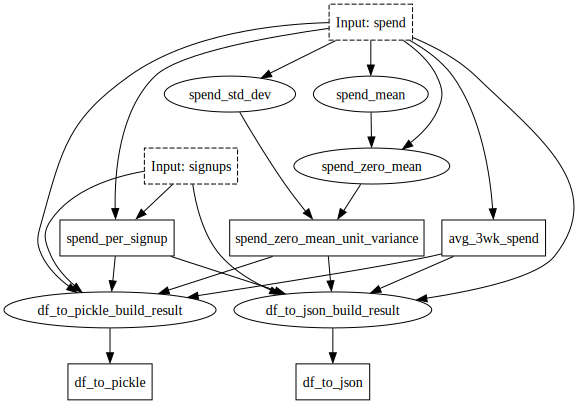

In [18]:
materializers = [
    # materialize the dataframe to a pickle file
    to.pickle(
        dependencies=output_columns,
        id="df_to_pickle",
        path="./df.pkl",
        combine=df_builder,
    ),
    # materialize the dataframe to a JSON file
    to.json(
        dependencies=output_columns,
        id="df_to_json",
        filepath_or_buffer="./df.json",
        combine=df_builder,
    ),
]
# Visualize what is happening
dr.visualize_materialization(
    *materializers,
    additional_vars=output_columns,
    inputs=initial_columns,
)

In [19]:
# Materialize a result, i.e. execute the DAG!
materialization_results, additional_outputs = dr.materialize(
    *materializers,
    additional_vars=[
        "df_to_pickle_build_result",
        "df_to_json_build_result",
    ],  # because combine is used, we can get that result here.
    inputs=initial_columns,
)

In [20]:
materialization_results

{'df_to_pickle': {'size': 1088,
  'path': './df.pkl',
  'last_modified': 1694758374.3349555,
  'timestamp': 1694772774.33507},
 'df_to_json': {'size': 428,
  'path': './df.json',
  'last_modified': 1694758374.33606,
  'timestamp': 1694772774.336193}}

In [21]:
additional_outputs["df_to_pickle_build_result"]

,spend,signups,avg_3wk_spend,spend_per_signup,spend_zero_mean_unit_variance
0,10,1,NaN,10.000,-1.064405
1,10,10,NaN,1.000,-1.064405
2,20,50,13.333333,0.400,-0.483821
3,40,100,23.333333,0.400,0.677349
4,40,200,33.333333,0.200,0.677349
5,50,400,43.333333,0.125,1.257934


In [22]:
additional_outputs["df_to_json_build_result"]

,spend,signups,avg_3wk_spend,spend_per_signup,spend_zero_mean_unit_variance
0,10,1,NaN,10.000,-1.064405
1,10,10,NaN,1.000,-1.064405
2,20,50,13.333333,0.400,-0.483821
3,40,100,23.333333,0.400,0.677349
4,40,200,33.333333,0.200,0.677349
5,50,400,43.333333,0.125,1.257934
